In [50]:
!pip install optuna
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,random_split, SubsetRandomSampler
from torch import nn
import optuna
import torch.optim as Optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import plotly.express as px

In [51]:
data_dir = 'dataset'
tr= transforms.Compose([transforms.ToTensor(),])
Train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True,transform = tr)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True, transform = tr)

In [52]:
train_dataset, val_dataset = random_split(Train_dataset, (50000, 10000))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [53]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

In [54]:
class AE3class(nn.Module):
    
    def __init__(self, encoded_space_dim,NumFL1,NumFL2,NumFL3,latent):
        super().__init__()
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x1 = self.encoder_lin(x)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(x1)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,x1

In [55]:
# for i,j in validation_dataloader: 
#     print(torch.randn_like(i))

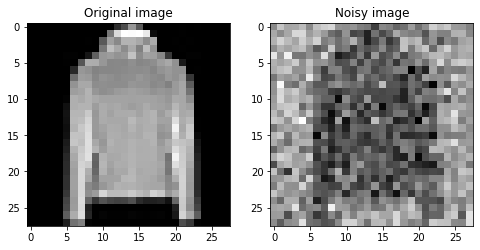

In [56]:
z=next(iter(validation_dataloader))
fig,ax = plt.subplots(1,2, figsize=[8,6] )
# print(z[0][0][0])
t = z[0][0][0]
s = torch.randn(28,28)*0.3
# plt.imshow(t+torch.randn_like(t),cmap='gray')
# plt.figure()
ax[1].imshow(t+s,cmap='binary')
ax[0].set_title("Original image")
ax[1].set_title("Noisy image")
ax[0].imshow(t,cmap='gray')

In [66]:
### Training function
def train_epoch(encoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    TRloss = []
    encoder.train() 
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch,_ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)

        image_batch = image_batch.to(device)
        guassian_nosie = torch.randn_like(image_batch)
        noisy_input = image_batch + guassian_nosie*0.3
        outImage,_ = encoder(noisy_input)

        loss = loss_fn(image_batch, outImage).to(device)
        TRloss.append(loss)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return TRloss
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [67]:
### Testing function
def test_epoch(encoder, device, dataloader, loss_fn):
    encoder.eval()
    batchValError = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data,_ = encoder(image_batch)
            
            conc_out.append(encoded_data.cpu())
            conc_label.append(image_batch.cpu())
            batchValError.append(loss_fn(encoded_data,image_batch).item())
        conc_out = torch.cat(conc_out)

        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError

In [93]:
def PlotReconstructed(org,recon,epoch=0,figurHeight=8,figureWidth=5): 
    fig, axs = plt.subplots(1, 2, figsize=(figurHeight,figureWidth))
    axs[0].imshow(org.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Input image')
    axs[1].imshow(recon.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)

In [94]:
def trainingLoop(Epoch,Model,trainL,validL,LossFun,Optimizer,plotEachEpoch=True):
    lossEpochTrain = []
    lossEpochValidation = []
    for epoch in range(Epoch):
        print('EPOCH %d/%d' % (epoch + 1, Epoch))
        lossEpochTrain = lossEpochTrain + train_epoch(encoder= Model, device= device, 
                                                      dataloader= trainL, loss_fn= LossFun, 
                                                      optimizer= Optimizer)

        valloss,temp = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
        lossEpochValidation = lossEpochValidation + temp
        print(valloss)
        print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, Epoch, valloss))

        # Get the output of a specific image (the test image at index 0 in this case)
        img = test_dataset[2][0].unsqueeze(0).to(device)
        guassian_nosie = torch.randn_like(img)
        noisy_input = img + guassian_nosie*0.3
        Model.eval()
        with torch.no_grad():
            rec_img,_  = Model(noisy_input)
        if plotEachEpoch:
            PlotReconstructed(org=noisy_input,recon=rec_img,epoch=epoch)
    final_val_loss,_ = test_epoch(encoder= Model, device= device, 
                                  dataloader= validL, loss_fn= LossFun)
    return lossEpochTrain,lossEpochValidation,final_val_loss
    # Plot the reconstructed image

In [95]:
loss_fn = torch.nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [96]:
torch.manual_seed(0)
encoded_space_dim = 3
ModelDAE = AE3class(encoded_space_dim=encoded_space_dim,NumFL1=16,NumFL2=32,NumFL3=64,latent=96)
# decoder = Decoder(encoded_space_dim=encoded_space_dim)

In [97]:
loss_fn = torch.nn.MSELoss()
lr = 0.005 # Learning rate
params_to_optimize = ModelDAE.parameters() 
ModelDAE.to(device)
print(device)
optim = torch.optim.Adam(params_to_optimize, lr=lr)

cuda


EPOCH 1/30
tensor(0.0287)


	 VALIDATION - EPOCH 1/30 - loss: 0.028742




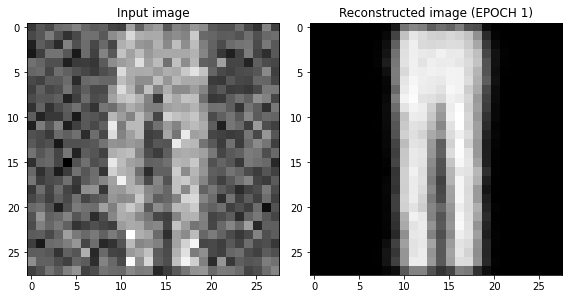

EPOCH 2/30
tensor(0.0266)


	 VALIDATION - EPOCH 2/30 - loss: 0.026563




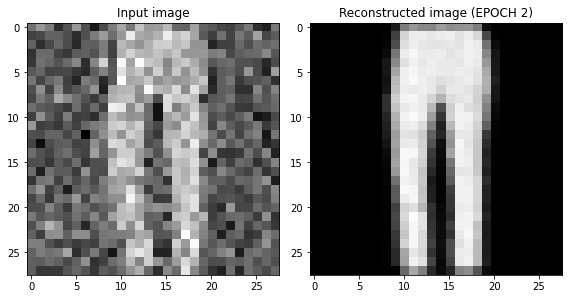

EPOCH 3/30
tensor(0.0251)


	 VALIDATION - EPOCH 3/30 - loss: 0.025136




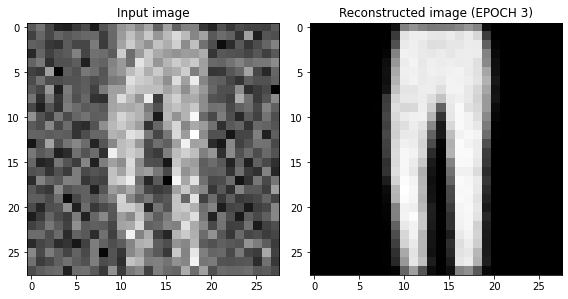

EPOCH 4/30
tensor(0.0245)


	 VALIDATION - EPOCH 4/30 - loss: 0.024530




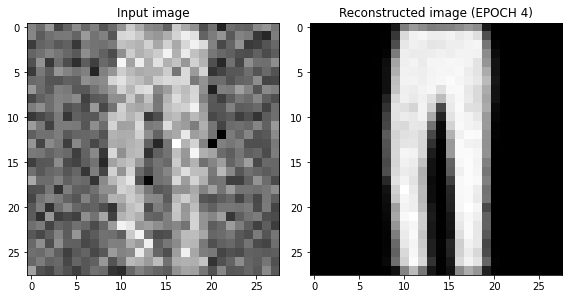

EPOCH 5/30
tensor(0.0242)


	 VALIDATION - EPOCH 5/30 - loss: 0.024191




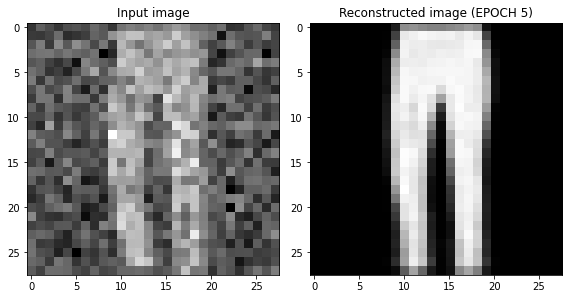

EPOCH 6/30
tensor(0.0239)


	 VALIDATION - EPOCH 6/30 - loss: 0.023880




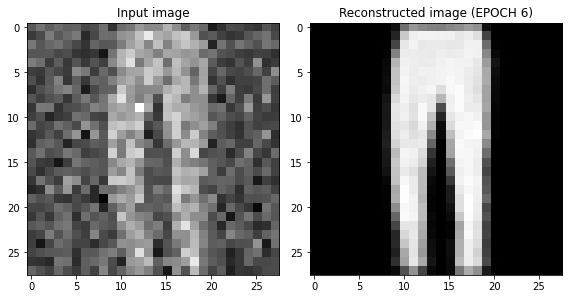

EPOCH 7/30
tensor(0.0235)


	 VALIDATION - EPOCH 7/30 - loss: 0.023513




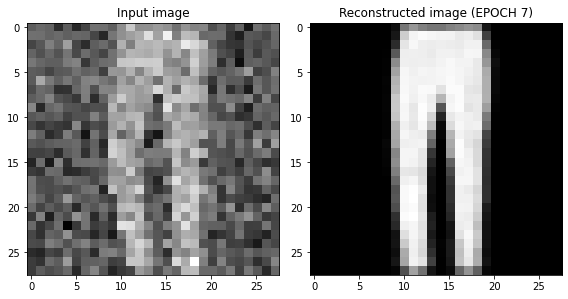

EPOCH 8/30
tensor(0.0232)


	 VALIDATION - EPOCH 8/30 - loss: 0.023157




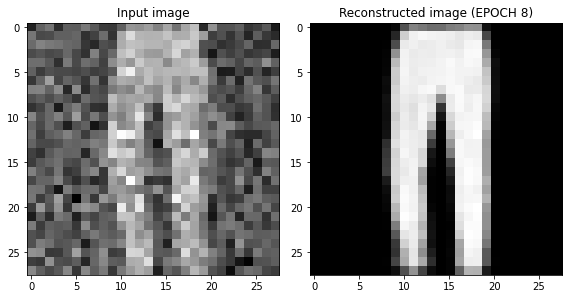

EPOCH 9/30
tensor(0.0229)


	 VALIDATION - EPOCH 9/30 - loss: 0.022900




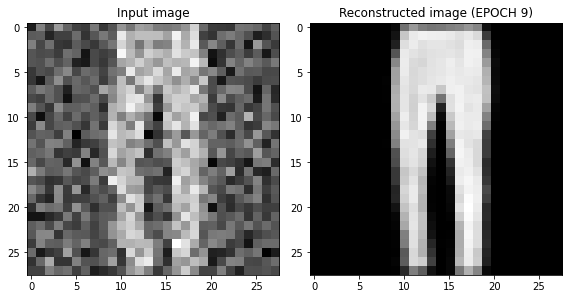

EPOCH 10/30
tensor(0.0229)


	 VALIDATION - EPOCH 10/30 - loss: 0.022948




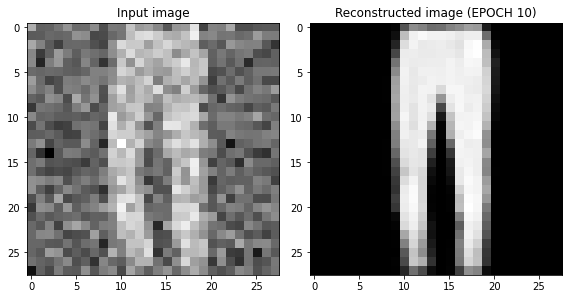

EPOCH 11/30
tensor(0.0231)


	 VALIDATION - EPOCH 11/30 - loss: 0.023100




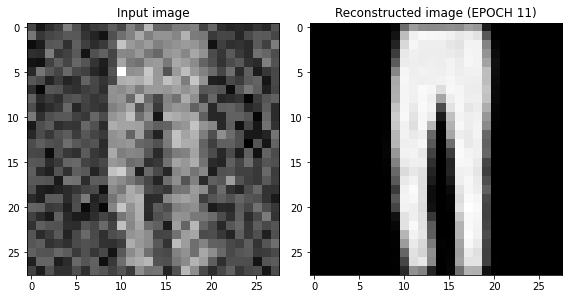

EPOCH 12/30
tensor(0.0227)


	 VALIDATION - EPOCH 12/30 - loss: 0.022681




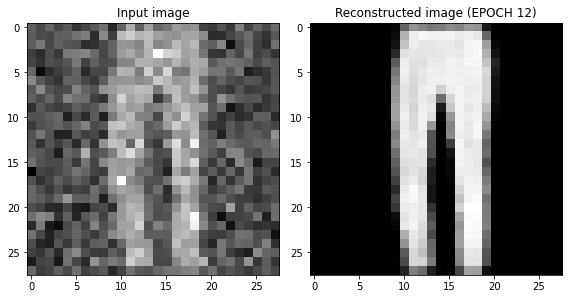

EPOCH 13/30
tensor(0.0226)


	 VALIDATION - EPOCH 13/30 - loss: 0.022602




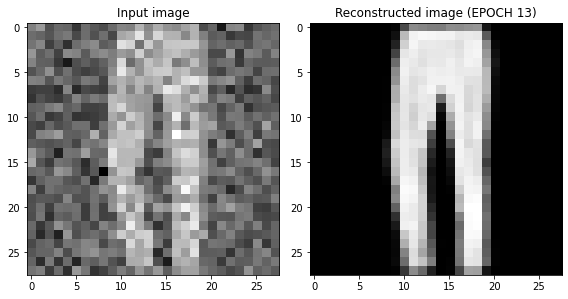

EPOCH 14/30
tensor(0.0229)


	 VALIDATION - EPOCH 14/30 - loss: 0.022870




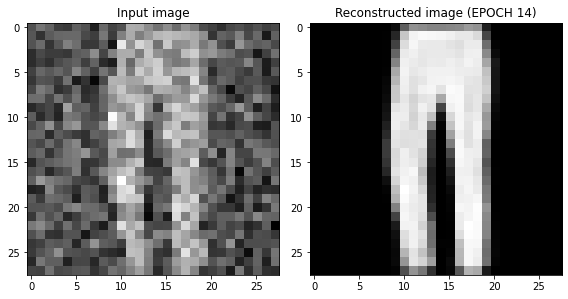

EPOCH 15/30
tensor(0.0222)


	 VALIDATION - EPOCH 15/30 - loss: 0.022247




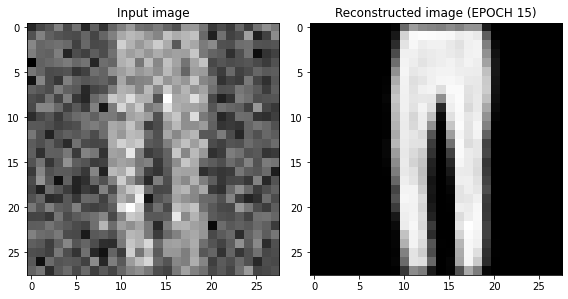

EPOCH 16/30
tensor(0.0223)


	 VALIDATION - EPOCH 16/30 - loss: 0.022301




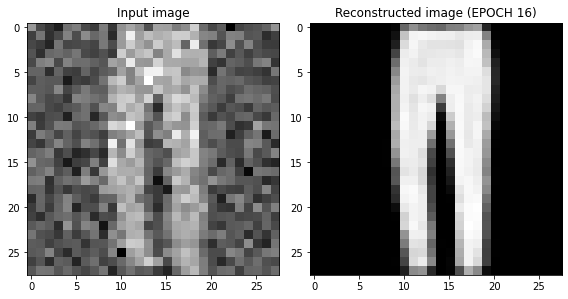

EPOCH 17/30
tensor(0.0222)


	 VALIDATION - EPOCH 17/30 - loss: 0.022151




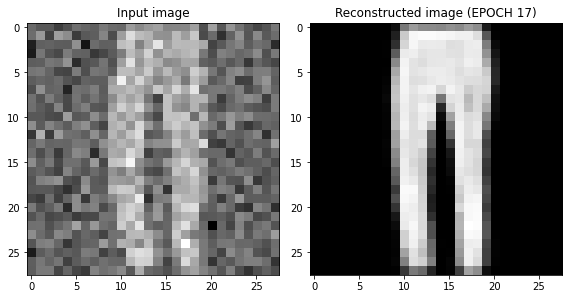

EPOCH 18/30
tensor(0.0223)


	 VALIDATION - EPOCH 18/30 - loss: 0.022311




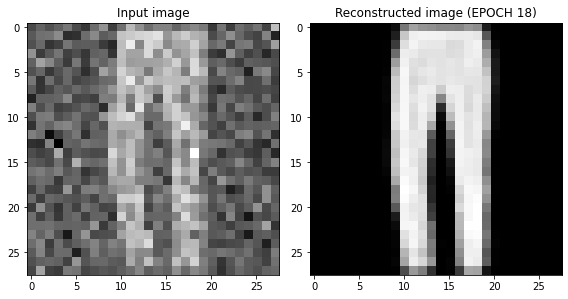

EPOCH 19/30
tensor(0.0220)


	 VALIDATION - EPOCH 19/30 - loss: 0.022018




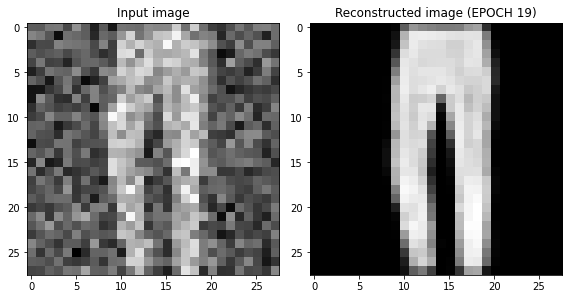

EPOCH 20/30
tensor(0.0218)


	 VALIDATION - EPOCH 20/30 - loss: 0.021835




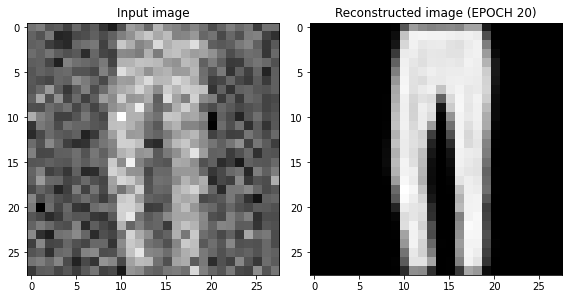

EPOCH 21/30
tensor(0.0217)


	 VALIDATION - EPOCH 21/30 - loss: 0.021729




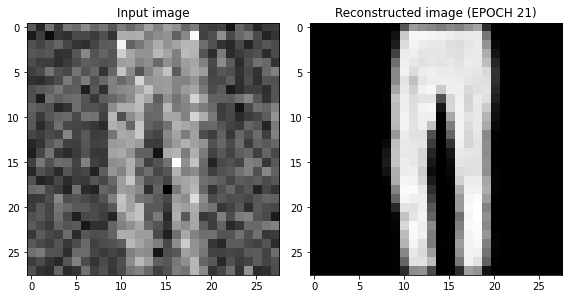

EPOCH 22/30
tensor(0.0219)


	 VALIDATION - EPOCH 22/30 - loss: 0.021923




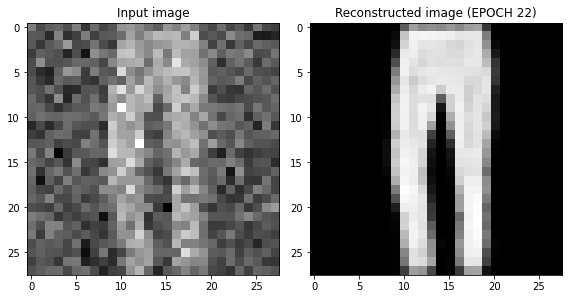

EPOCH 23/30
tensor(0.0219)


	 VALIDATION - EPOCH 23/30 - loss: 0.021915




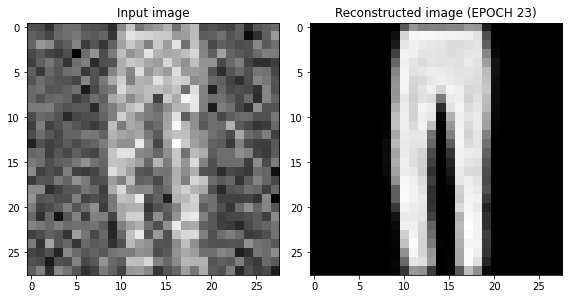

EPOCH 24/30
tensor(0.0220)


	 VALIDATION - EPOCH 24/30 - loss: 0.021982




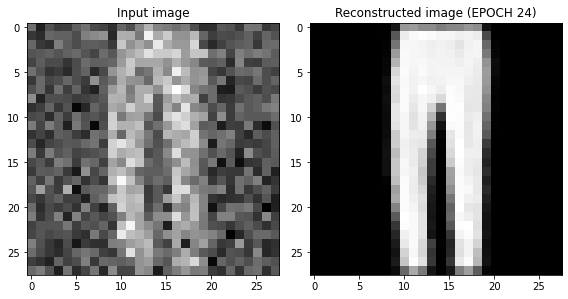

EPOCH 25/30
tensor(0.0218)


	 VALIDATION - EPOCH 25/30 - loss: 0.021796




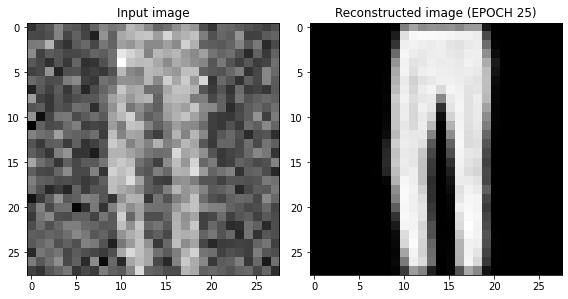

EPOCH 26/30
tensor(0.0217)


	 VALIDATION - EPOCH 26/30 - loss: 0.021663




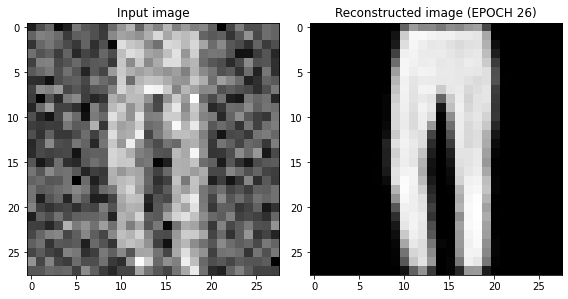

EPOCH 27/30
tensor(0.0218)


	 VALIDATION - EPOCH 27/30 - loss: 0.021755




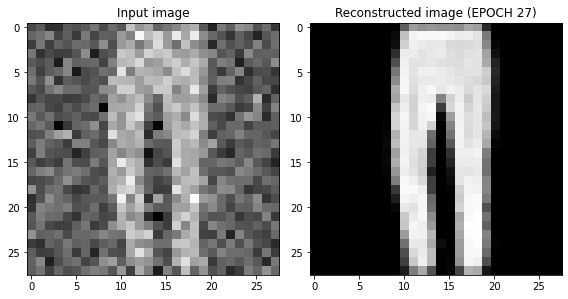

EPOCH 28/30
tensor(0.0215)


	 VALIDATION - EPOCH 28/30 - loss: 0.021527




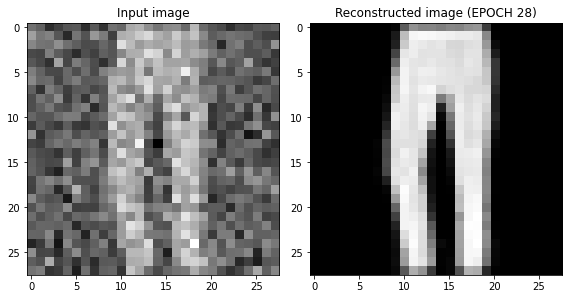

EPOCH 29/30
tensor(0.0216)


	 VALIDATION - EPOCH 29/30 - loss: 0.021574




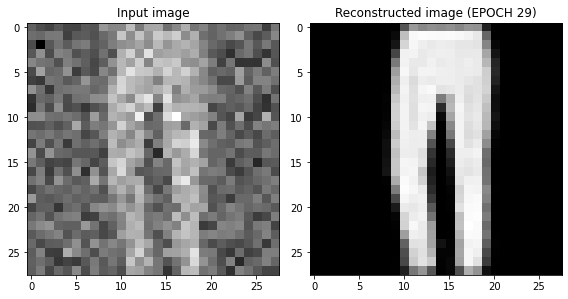

EPOCH 30/30
tensor(0.0214)


	 VALIDATION - EPOCH 30/30 - loss: 0.021357




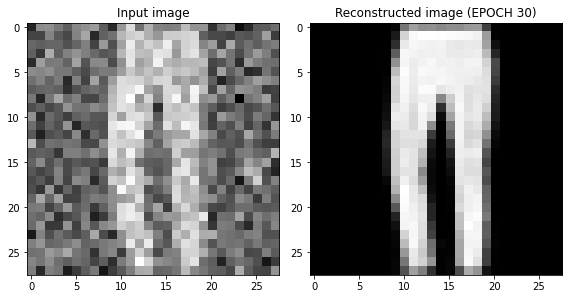

In [98]:
tre,vale,finalerr = trainingLoop(Epoch=30,Model=ModelDAE,
                                 trainL=train_dataloader,
                                 validL=validation_dataloader,
                                 LossFun=loss_fn,Optimizer=optim)

In [99]:
PATH = "DAE3.pth"
torch.save(ModelDAE.state_dict(), PATH)
from google.colab import files
files.download(PATH) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

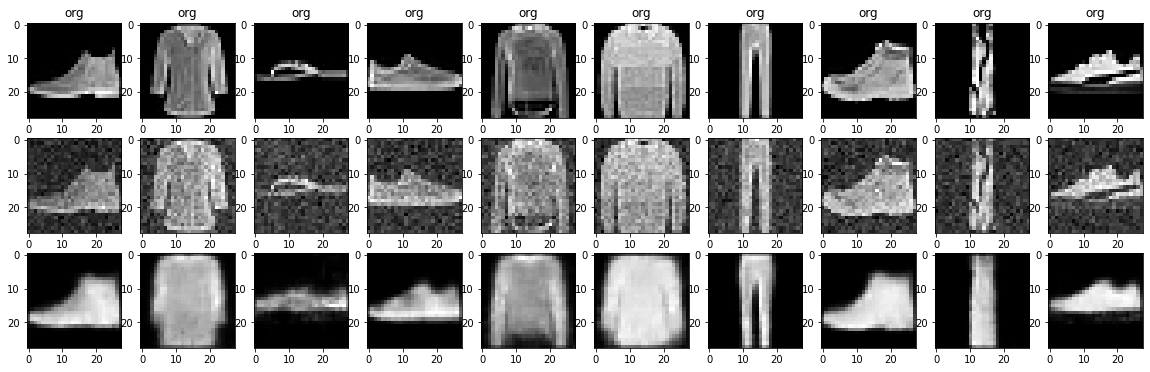

In [115]:
fig,ax = plt.subplots(3,10,figsize=(20,6))
for i in range(10):
    img1 = test_dataset[4*i][0].unsqueeze(0).to(device)
    img = img1 + torch.randn_like(img1)*0.1
    ModelDAE.eval()
    with torch.no_grad():
        rec_img,_  = ModelDAE(img)
    # PlotReconstructed(org=img,recon=rec_img)
    ax[0,i].imshow(img1.to("cpu").squeeze().numpy(), cmap='gist_gray')
    ax[0,i].set_title("org")
    ax[1,i].imshow(img.to("cpu").squeeze().numpy(), cmap='gist_gray')
    ax[2,i].imshow(rec_img.to("cpu").squeeze().numpy(), cmap='gist_gray')

In [ ]:
Z = []
for i in tre:
    Z.append(i.detach().numpy())
plt.plot(range(len(tre)),Z)
plt.figure()
plt.plot(range(len(vale)),vale)
